Ref: https://www.kaggle.com/code/ritvik1909/speech-classification-spectrogram-cnn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import math

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [11]:
# !pip3 install seaborn
# !pip3 install tensorflow
import seaborn as sns
import soundfile as sf
import os, random, librosa
from tqdm.auto import tqdm
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

ECS7020P_miniproject_submission_2_CNN.ipynb
ECS7020P_miniproject_submission_2_pitch-Copy1.ipynb
ECS7020P_miniproject_submission_7_dec_stft.ipynb
ECS7020P_miniproject_submission_7_dec_testing.ipynb
ECS7020P_miniproject_submission_8_Dec_MFCC.ipynb
ECS7020P_miniproject_submission_advanced_cnn.ipynb
ECS7020P_miniproject_submission_advanced_stft.ipynb
ECS7020P_miniproject_submission_base.ipynb
mel_spectrograms
MLEnd_2022_Starter_kit.ipynb
MLEndLS
MLEndLS.csv


In [2]:
sample_path = 'MLEndLS/*.wav'
files = glob.glob(sample_path)
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 

In [3]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['in_out', 'area']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

input_data = column_transformer.fit_transform(MLENDLS_df)
input_data = pd.DataFrame(data=input_data, columns=column_transformer.get_feature_names_out())

labels = MLENDLS_df['spot'].to_numpy()

input_data = input_data.drop(columns=[
    'Participant',
    'spot',
])

display(input_data)
display(labels)

,in_out_indoor,in_out_outdoor,area_Euston,area_british,area_campus,area_kensington,area_southbank,area_westend
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2496,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2498,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


array(['street', 'dinosaur', 'square', ..., 'national', 'room12',
       'room12'], dtype=object)

In [4]:
class config:
    CLASSES = np.array(MLENDLS_df['spot'].unique())
    MAX_EPOCHS = 500

In [5]:
def get_mel_spectrogram(sound_wave, sr, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sr * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sr, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

class_distribution = []
spectrogram_samples = []
audio_samples = []

DATA = 'mel_spectrograms'

if not os.path.exists(DATA):
    os.mkdir(DATA)

for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    
    meta_info = MLENDLS_df.loc[fileID]
    
    dst_dir = os.path.join(DATA, meta_info['spot'])
    
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)    

    waveform, sr = librosa.load(file)
    waveform = waveform[:143766]
    
    if len(waveform) < 143766: continue

    class_distribution.append(meta_info['spot'])
    dst_path = f"{os.path.join(dst_dir, file_name)}.png"
    
    plt.imsave(dst_path, get_mel_spectrogram(waveform, sr), cmap='gray')

    spectrogram_samples.append(dst_path)
    audio_samples.append(file_name)

print('done')

100%|██████████████████████████████████████| 2500/2500 [10:31<00:00,  3.96it/s]

done


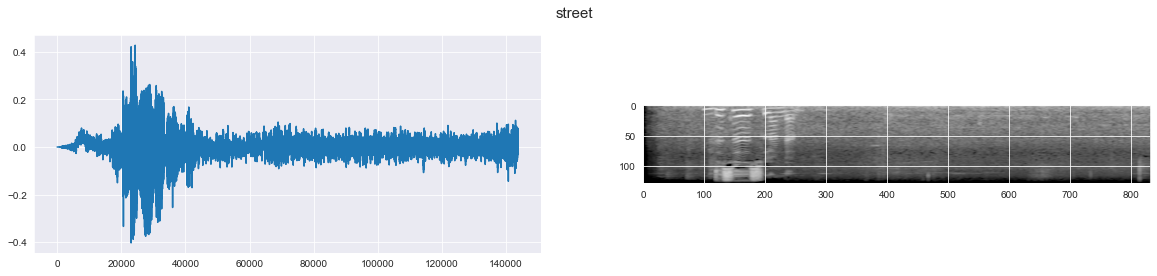

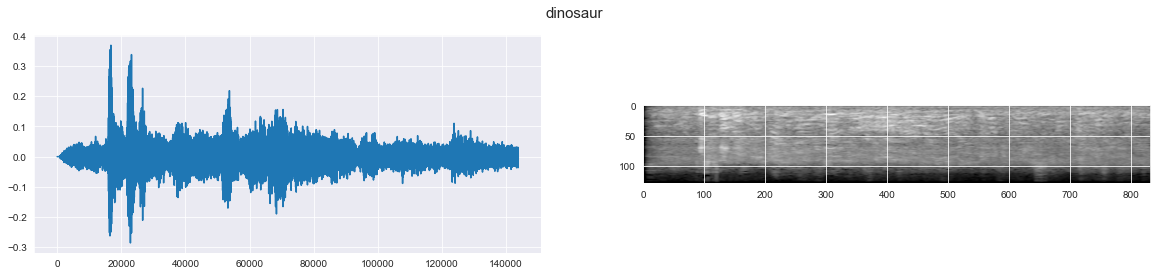

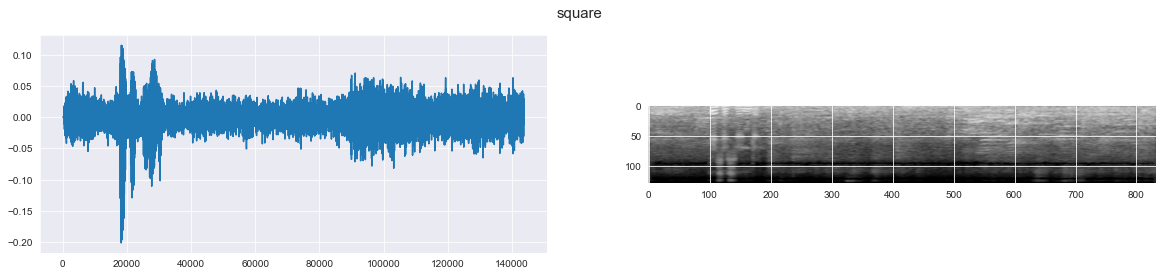

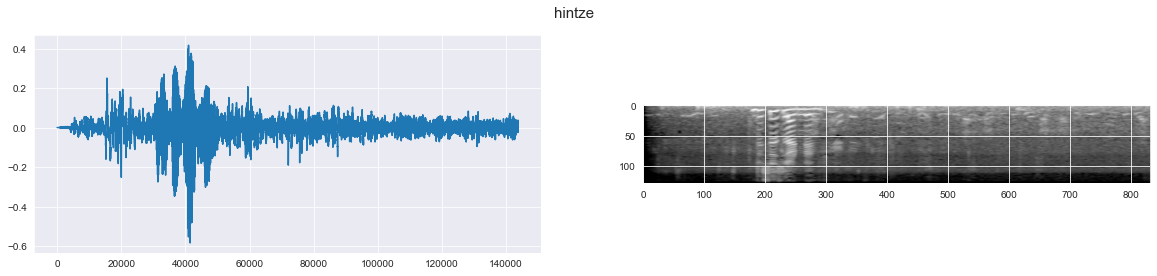

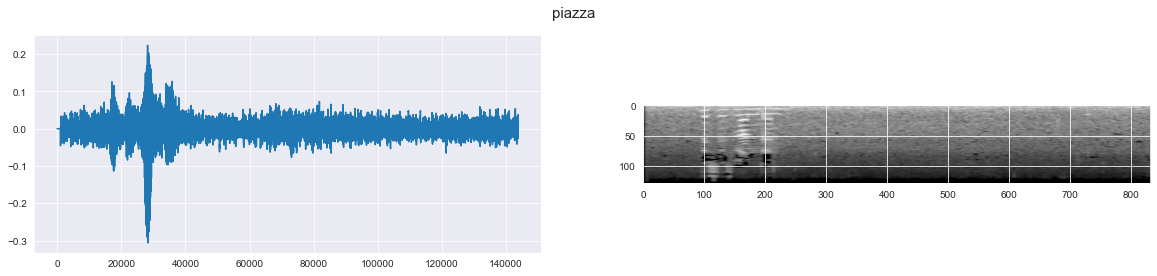

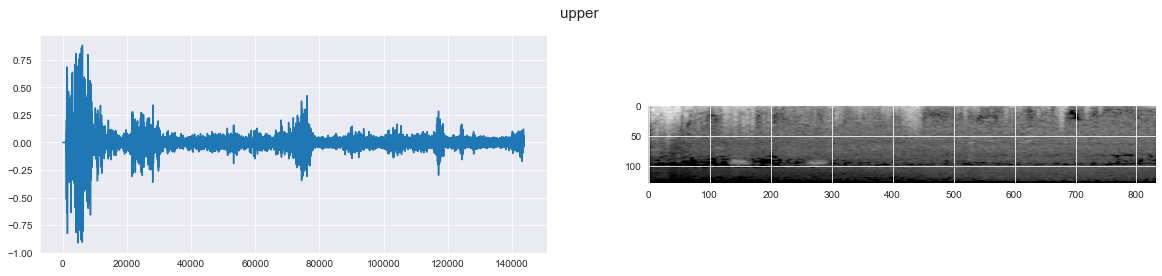

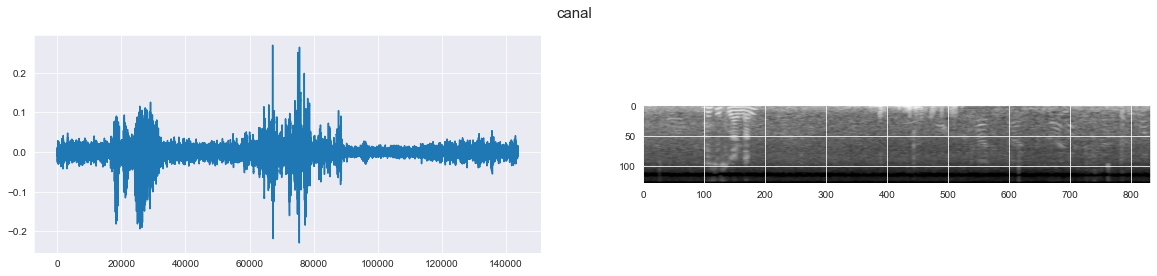

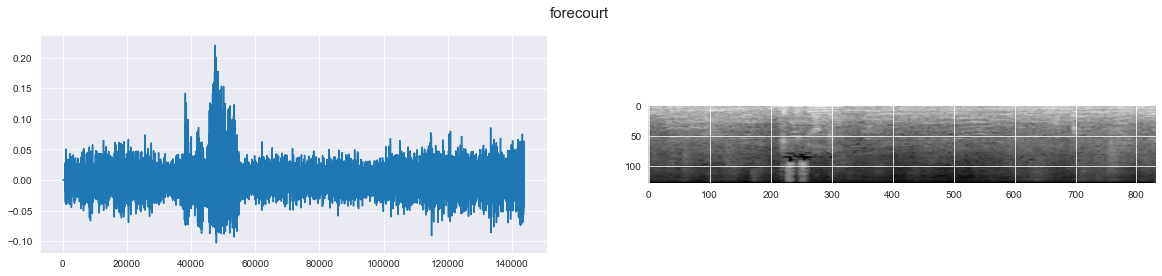

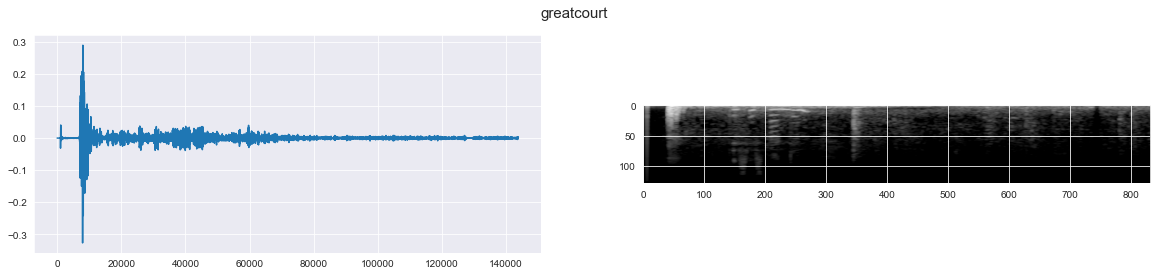

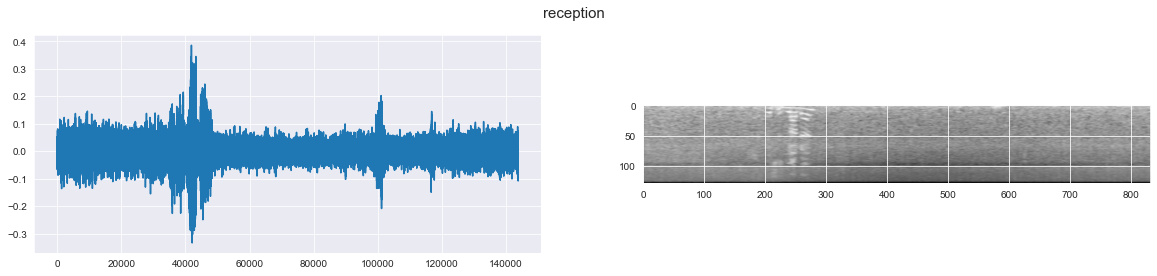

In [17]:
for i in range(10):
    waveform, sr = librosa.load(files[i])
    waveform = waveform[:143766]
    fig, ax = plt.subplots(1,2, figsize=(20, 4))
    ax[0].plot(waveform)
    ax[1].imshow(plt.imread(spectrogram_samples[i]), cmap='gray')
    fig.suptitle(config.CLASSES[i], fontsize=15);

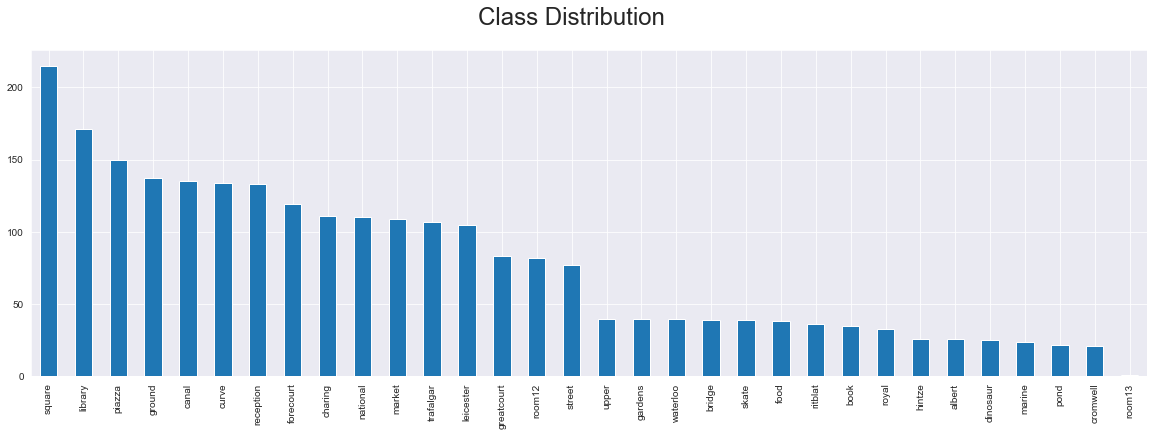

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.Series(class_distribution).value_counts().plot.bar()
fig.suptitle('Class Distribution', fontsize=24);

In [12]:
image_size = (832, 128, 1)
datagen = ImageDataGenerator(validation_split=0.1)

training_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='training'
)
validation_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='validation'
)

Found 2235 images belonging to 32 classes.
Found 236 images belonging to 32 classes.


In [14]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=image_size, padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(config.CLASSES), activation='softmax'),
])

model.summary()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

2022-12-09 10:04:10.850846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 10:04:10.851193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 10:04:10.851316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-09 10:04:10.851408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-09 10:04:10.851497: W tensorflow/c

In [15]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-10, mode='min', verbose=1)

history = model.fit(
    training_set, validation_data=validation_set,
    epochs=config.MAX_EPOCHS, callbacks=[es, rlp], batch_size=8
)

In [16]:
# Results

'''
    CONCULSION:
    An accuracy of 33% on a data set with 32 classes, i.e. worst case accuracy 
    for this data set would be 3%, therefore an accuracy of 33% is a good, albiet
    not a good enough result
'''

Epoch 1/500
70/70 [==============================] - 53s 744ms/step - loss: 4.0524 - accuracy: 0.0564 - val_loss: 3.2822 - val_accuracy: 0.0890 - lr: 0.0010
Epoch 2/500
70/70 [==============================] - 57s 808ms/step - loss: 3.2599 - accuracy: 0.0707 - val_loss: 3.2816 - val_accuracy: 0.0551 - lr: 0.0010
Epoch 3/500
70/70 [==============================] - 56s 803ms/step - loss: 3.2442 - accuracy: 0.0694 - val_loss: 3.2242 - val_accuracy: 0.0890 - lr: 0.0010
Epoch 4/500
70/70 [==============================] - 55s 788ms/step - loss: 3.2245 - accuracy: 0.0931 - val_loss: 3.1522 - val_accuracy: 0.1017 - lr: 0.0010
Epoch 5/500
70/70 [==============================] - 56s 797ms/step - loss: 3.1800 - accuracy: 0.1056 - val_loss: 3.0756 - val_accuracy: 0.1568 - lr: 0.0010
Epoch 6/500
70/70 [==============================] - 56s 796ms/step - loss: 3.1509 - accuracy: 0.1114 - val_loss: 3.0473 - val_accuracy: 0.1568 - lr: 0.0010
Epoch 7/500
70/70 [==============================] - 57s 8

# 8 Results

Carry out your experiments here, explain your results.

  
  
--------------------------------------
--------------------------------------
--------------------------------------
  
  
  

# 9 Conclusions

Your conclusions, improvements, etc should go here